## Fact Checking

In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [2]:
# Read Data
df = pd.read_csv('dataset/fake_or_real_news/fake_or_real_news.csv')
data_fake = df[['title', 'text']].apply(lambda x: '. '.join(x), axis=1).values
label_fake = np.where(df['label']=='FAKE', 0, 1)
del df

In [3]:
def transform_to_feature(X_train, X_test, X_valid=None, feature='tfidf'):
    if feature=='count':
        vectorizer = CountVectorizer(stop_words='english')
        features_train = vectorizer.fit_transform(X_train)
        features_test = vectorizer.transform(X_test)
        try:
            features_valid = vectorizer.transform(X_valid)
        except:
            features_valid = None
            print('No-Validation-Set')
    else:
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
        features_train = vectorizer.fit_transform(X_train)
        features_test = vectorizer.transform(X_test)
        try:
            features_valid = vectorizer.transform(X_valid)
        except:
            features_valid = None            
            print('No-Validation-Set')
            
    return features_train, features_test, vectorizer, features_valid

def classifier(name):
    if name == 'logistic':
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression()       
    elif name == 'decision-tree':
        from sklearn.tree import DecisionTreeClassifier
        clf = DecisionTreeClassifier()       
    elif name =='MLP':
        from sklearn.neural_network import MLPClassifier
        clf = MLPClassifier(alpha=1)
    elif name == 'GaussianNB':
        from sklearn.naive_bayes import GaussianNB
        clf = GaussianNB()
    elif name == 'MultinomialNB':
        from sklearn.naive_bayes import MultinomialNB
        clf = MultinomialNB()
    else:
        raise NotImplementedError('Classifier not implemented.')    
    
    return clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## Configuration-1

In [4]:
def cross_validation(model, features_train, train_label, features_test, test_label, K=5, random_state=4222):
    k_fold = StratifiedKFold(n_splits=K,random_state=random_state)
    accuracy_train, accuracy_validation, accuracy_test = np.empty(5), np.empty(5), np.empty(5)
    precision_train, precision_validation, precision_test  = np.empty(5), np.empty(5), np.empty(5)
    recall_train, recall_validation, recall_test  = np.empty(5), np.empty(5), np.empty(5)

    for k, (train, validation) in enumerate(k_fold.split(features_train, train_label)):
        model.fit(features_train[train], train_label[train])
        print("[fold {0}], Validation Score: {1:.5f}".format(k, model.score(features_train[validation], train_label[validation])))
        train_pred = model.predict(features_train[train])
        accuracy_train[k]= accuracy_score(train_label[train], train_pred)
        precision_train[k]= precision_score(train_label[train], train_pred)
        recall_train[k] = recall_score(train_label[train], train_pred)

        validation_pred = model.predict(features_train[validation])
        accuracy_validation[k]= accuracy_score(train_label[validation], validation_pred)
        precision_validation[k]= precision_score(train_label[validation], validation_pred)
        recall_validation[k] = recall_score(train_label[validation], validation_pred)

        test_pred = model.predict(features_test)
        accuracy_test[k]= accuracy_score(test_pred, test_label)
        precision_test[k]= precision_score(test_pred, test_label)
        recall_test[k] = recall_score(test_pred, test_label)

    print("Accuracy Training Set: {0:.2f} (+/- {1:.2f})".format(accuracy_train.mean(), accuracy_train.std() * 2))
    print("Precision Training Set: {0:.2f} (+/- {1:.2f})".format(precision_train.mean(), precision_train.std() * 2))
    print("Recall Training Set: {0:.2f} (+/- {1:.2f})".format(recall_train.mean(), recall_train.std() * 2))
    
    print("Accuracy Validation Set: {0:.2f} (+/- {1:.2f})".format(accuracy_validation.mean(), accuracy_validation.std() * 2))
    print("Precision Validation Set: {0:.2f} (+/- {1:.2f})".format(precision_validation.mean(), precision_validation.std() * 2))
    print("Recall Validation Set: {0:.2f} (+/- {1:.2f})".format(recall_validation.mean(), recall_validation.std() * 2))
    
    print("Accuracy Test Set: {0:.2f} (+/- {1:.2f})".format(accuracy_test.mean(), accuracy_test.std() * 2))
    print("Precision Test Set: {0:.2f} (+/- {1:.2f})".format(precision_test.mean(), precision_test.std() * 2))
    print("Recall Test Set: {0:.2f} (+/- {1:.2f})".format(recall_test.mean(), recall_test.std() * 2))


No-Validation-Set
[fold 0], Validation Score: 0.83281
[fold 1], Validation Score: 0.84316
[fold 2], Validation Score: 0.84316
[fold 3], Validation Score: 0.82000
[fold 4], Validation Score: 0.81579
Accuracy Training Set: 0.90 (+/- 0.00)
Precision Training Set: 0.84 (+/- 0.01)
Recall Training Set: 0.99 (+/- 0.00)
Accuracy Validation Set: 0.83 (+/- 0.02)
Precision Validation Set: 0.75 (+/- 0.02)
Recall Validation Set: 0.98 (+/- 0.01)
Accuracy Test Set: 0.84 (+/- 0.01)
Precision Test Set: 0.98 (+/- 0.01)
Recall Test Set: 0.76 (+/- 0.01)
Confusion matrix, without normalization


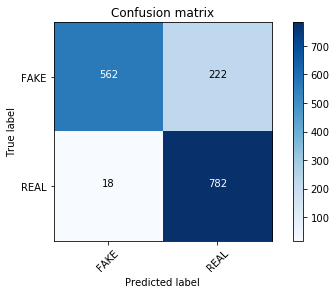

In [5]:
model_a = classifier('MultinomialNB')
# Split Data
train_data_fake, test_data_fake, train_label_fake, test_label_fake = train_test_split(data_fake, label_fake, test_size=0.25, shuffle=True)
features_train_fake, features_test_fake, vectorizer_fake,_ = transform_to_feature(train_data_fake, test_data_fake, feature='tfidf')
cross_validation(model_a, features_train_fake, train_label_fake, features_test_fake, test_label_fake, K=5)

model_a.fit(features_train_fake, train_label_fake)
y_pred_fake = model_a.predict(features_test_fake)
cm = confusion_matrix(test_label_fake, y_pred_fake)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [6]:
model_a

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Configuration 2

In [7]:
df_train = pd.read_csv('dataset/liar_dataset/train.tsv', sep='\t', header=None)
train_label_liar, train_data_liar = df_train[1].values, df_train[2].values
train_label_liar = np.where(train_label_liar=='false',0,1)

df_valid = pd.read_csv('dataset/liar_dataset/valid.tsv', sep='\t', header=None)
valid_label_liar, valid_data_liar = df_valid[1].values, df_valid[2].values
valid_label_liar = np.where(valid_label_liar=='false',0,1)


df_test = pd.read_csv('dataset/liar_dataset/test.tsv', sep='\t', header=None)
test_label_liar, test_data_liar = df_test[1].values, df_test[2].values
test_label_liar = np.where(test_label_liar=='false',0,1)

features_train_liar, features_test_liar, vectorizer_liar, features_valid_liar = transform_to_feature(train_data_liar, test_data_liar, valid_data_liar, feature='tfidf')

In [8]:
train_label_liar

array([0, 1, 1, ..., 1, 0, 1])

Accuracy Training Set: 1.00 
Precision Training Set: 1.00 
Recall Training Set: 1.00 
Accuracy Validation Set: 0.71 
Precision Validation Set: 0.84 
Recall Validation Set: 0.81 
Accuracy Test Set: 0.72 
Precision Test Set: 0.85 
Recall Test Set: 0.81 
Confusion matrix, without normalization


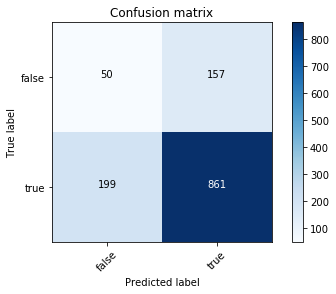

In [9]:
model_b = classifier('decision-tree')

model_b.fit(features_train_liar, train_label_liar)
train_pred_liar = model_b.predict(features_train_liar)
print("Accuracy Training Set: {0:.2f} ".format(accuracy_score(train_pred_liar, train_label_liar)))
print("Precision Training Set: {0:.2f} ".format(precision_score(train_pred_liar, train_label_liar)))
print("Recall Training Set: {0:.2f} ".format(recall_score(train_pred_liar, train_label_liar)))
                                                          
valid_pred_liar = model_b.predict(features_valid_liar)
print("Accuracy Validation Set: {0:.2f} ".format(accuracy_score(valid_pred_liar, valid_label_liar)))
print("Precision Validation Set: {0:.2f} ".format(precision_score(valid_pred_liar, valid_label_liar)))
print("Recall Validation Set: {0:.2f} ".format(recall_score(valid_pred_liar, valid_label_liar)))

test_pred_liar = model_b.predict(features_test_liar)
print("Accuracy Test Set: {0:.2f} ".format(accuracy_score(test_pred_liar, test_label_liar)))
print("Precision Test Set: {0:.2f} ".format(precision_score(test_pred_liar, test_label_liar)))
print("Recall Test Set: {0:.2f} ".format(recall_score(test_pred_liar, test_label_liar)))
                                                    
cm = confusion_matrix(test_pred_liar, test_label_liar)
plot_confusion_matrix(cm, classes=['false', 'true'])

In [10]:
model_b

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Confuguration-3

Accuracy Test Set: 0.74)
Precision Test Set: 0.88)
Recall Test Set: 0.81)
Confusion matrix, without normalization


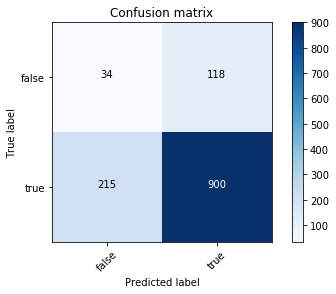

In [11]:
# Check Model_a on Dataset 2
features_test_liar2 = vectorizer_fake.transform(test_data_liar)
test_pred_liar_2 = model_a.predict(features_test_liar2)
print("Accuracy Test Set: {0:.2f})".format(accuracy_score(test_pred_liar_2, test_label_liar)))
print("Precision Test Set: {0:.2f})".format(precision_score(test_pred_liar_2, test_label_liar)))
print("Recall Test Set: {0:.2f})".format(recall_score(test_pred_liar_2, test_label_liar)))
cm = confusion_matrix(test_pred_liar_2, test_label_liar)
plot_confusion_matrix(cm, classes=['false', 'true'])

Accuracy Test Set: 0.50)
Precision Test Set: 0.85)
Recall Test Set: 0.50)
Confusion matrix, without normalization


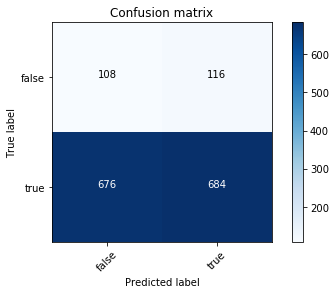

In [12]:
# Check Model_b on Dataset 1
features_test_fake2 = vectorizer_liar.transform(test_data_fake)
test_pred_fake_2 = model_b.predict(features_test_fake2)
print("Accuracy Test Set: {0:.2f})".format(accuracy_score(test_pred_fake_2, test_label_fake)))
print("Precision Test Set: {0:.2f})".format(precision_score(test_pred_fake_2, test_label_fake)))
print("Recall Test Set: {0:.2f})".format(recall_score(test_pred_fake_2, test_label_fake)))
cm = confusion_matrix(test_pred_fake_2, test_label_fake)
plot_confusion_matrix(cm, classes=['false', 'true'])

## Configuration 4

In [13]:
dataset3 = np.concatenate((train_data_liar, valid_data_liar, data_fake), axis=0)
label3 = np.concatenate((train_label_liar, valid_label_liar, label_fake), axis=0)

train_data, test_data, train_label, test_label = train_test_split(dataset3, label3, test_size=0.25, shuffle=True)
test_data = np.concatenate((test_data, test_data_liar), axis=0)
test_label = np.concatenate((test_label, test_label_liar), axis=0)
features_train, features_test, vectorizer, _ = transform_to_feature(train_data, test_data, feature='tfidf')

No-Validation-Set


Accuracy Training Set: 0.86 
Precision Training Set: 0.99 
Recall Training Set: 0.83 
Accuracy Test Set: 0.81 
Precision Test Set: 0.98 
Recall Test Set: 0.80 
Confusion matrix, without normalization


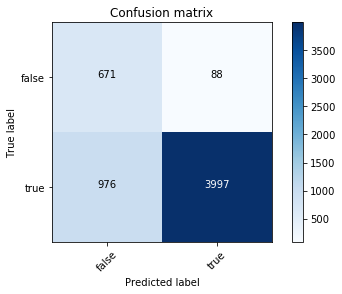

In [14]:
model_c = classifier('logistic')

model_c.fit(features_train.todense(), train_label)
train_pred = model_c.predict(features_train.todense())
print("Accuracy Training Set: {0:.2f} ".format(accuracy_score(train_pred, train_label)))
print("Precision Training Set: {0:.2f} ".format(precision_score(train_pred, train_label)))
print("Recall Training Set: {0:.2f} ".format(recall_score(train_pred, train_label)))

test_pred = model_c.predict(features_test.todense())
print("Accuracy Test Set: {0:.2f} ".format(accuracy_score(test_pred, test_label)))
print("Precision Test Set: {0:.2f} ".format(precision_score(test_pred, test_label)))
print("Recall Test Set: {0:.2f} ".format(recall_score(test_pred, test_label)))
                                                    
cm = confusion_matrix(test_pred, test_label)
plot_confusion_matrix(cm, classes=['false', 'true'])

In [15]:
model_c

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Saving MetaData as RDF

In [4]:
from rdflib import Namespace, Graph, Literal
from rdflib.namespace import FOAF, OWL, XSD, RDFS, DCTERMS, DOAP, DC, RDF


prov = Namespace('http://www.w3.org/ns/prov#')
dcat = Namespace('http://www.w3.org/ns/dcat#')
mexalgo = Namespace('http://mex.aksw.org/mex-algo#')
mexperf = Namespace('http://mex.aksw.org/mex-perf#')
mexcore = Namespace('http://mex.aksw.org/mex-core#')
this = Namespace('http://mex.aksw.org/examples/')

g = Graph()
# Create Binding
g.bind('dct',DCTERMS)
g.bind('owl',OWL)
g.bind('foaf',FOAF)
g.bind('xsd', XSD)
g.bind('rdfs', RDFS)
g.bind('doap', DOAP)
g.bind('dc', DC)
g.bind('prov', prov)
g.bind('dcat', dcat)
g.bind('mexalgo',mexalgo)
g.bind('mexperf',mexperf)
g.bind('mexcore',mexcore)
g.bind('this',this)

g.add((this.khan_task2,RDF.type, mexcore.Experiment))
g.add((this.khan_task2,RDF.type, mexcore.ApplicationContext))
g.add((this.khan_task2,RDFS.label, Literal('2255383')))
g.add((this.khan_task2,DCTERMS.date, Literal('2018-05-15',datatype=XSD.date)))
g.add((this.khan_task2,FOAF.givenName, Literal('Asif')))
g.add((this.khan_task2,FOAF.mbox, Literal('mak4086@gmail.com')))

#Configuration-1
g.add((this.configuration1,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration1,prov.used, this.model1))
g.add((this.configuration1,prov.wasStartedBy, this.khan_task2))

#Configuration-2
g.add((this.configuration2,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration2,prov.used, this.model2))
g.add((this.configuration2,prov.wasStartedBy, this.khan_task2))

#Configuration-3
g.add((this.configuration3,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration3,prov.used, this.model2))
g.add((this.configuration3,prov.used, this.model1))
g.add((this.configuration3,prov.wasStartedBy, this.khan_task2))

#Configuration-4
g.add((this.configuration4,RDF.type,mexcore.ExperimentConfiguration))
g.add((this.configuration4,prov.used, this.model4))
g.add((this.configuration4,prov.wasStartedBy, this.khan_task2))

g.add((this.test,RDF.type,mexcore.Test))
g.add((this.test,RDFS.label,Literal('Test')))

g.add((this.hyerparameter_model1,RDF.type,mexalgo.HyperParameterCollection))
g.add((this.hyerparameter1,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model1,prov.hadMember,this.hyerparameter1))

g.add((this.hyerparameter_model2,RDF.type,mexalgo.HyperParameterCollection))
g.add((this.hyerparameter_model2,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter2))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter3))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter4))
g.add((this.hyerparameter_model2,prov.hadMember,this.hyerparameter5))


g.add((this.hyerparameter_model4,RDF.type,mexalgo.HyperParameterCollection))
g.add((this.hyerparameter_model4,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model4,prov.hadMember,this.hyerparameter6))
g.add((this.hyerparameter_model4,prov.hadMember,this.hyerparameter7))
g.add((this.hyerparameter_model4,prov.hadMember,this.hyerparameter8))



g.add((this.hyerparameter1,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter1,RDFS.label, Literal('alpha')))
g.add((this.hyerparameter1,DCTERMS.identifier, Literal('alpha')))
g.add((this.hyerparameter1,prov.value, Literal('1.0',datatype=XSD.float)))

g.add((this.hyerparameter2,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter2,RDFS.label, Literal('min_samples_split')))
g.add((this.hyerparameter2,DCTERMS.identifier, Literal('min_samples_split')))
g.add((this.hyerparameter2,prov.value, Literal('2',datatype=XSD.integer)))

g.add((this.hyerparameter3,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter3,RDFS.label, Literal('min_samples_leaf')))
g.add((this.hyerparameter3,DCTERMS.identifier, Literal('min_samples_leaf')))
g.add((this.hyerparameter3,prov.value, Literal('1',datatype=XSD.integer)))

g.add((this.hyerparameter4,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter4,RDFS.label, Literal('splitter')))
g.add((this.hyerparameter4,DCTERMS.identifier, Literal('splitter')))
g.add((this.hyerparameter4,prov.value, Literal('best')))

g.add((this.hyerparameter5,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter5,RDFS.label, Literal('criterion')))
g.add((this.hyerparameter5,DCTERMS.identifier, Literal('criterion')))
g.add((this.hyerparameter5,prov.value, Literal('gini')))

g.add((this.hyerparameter6,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter6,RDFS.label, Literal('max_iter')))
g.add((this.hyerparameter6,DCTERMS.identifier, Literal('max_iter')))
g.add((this.hyerparameter6,prov.value, Literal('100',datatype=XSD.integer)))

g.add((this.hyerparameter7,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter7,RDFS.label, Literal('penalty')))
g.add((this.hyerparameter7,DCTERMS.identifier, Literal('penalty')))
g.add((this.hyerparameter7,prov.value, Literal('l2')))


g.add((this.hyerparameter8,RDF.type,mexalgo.HyperParameter))
g.add((this.hyerparameter8,RDFS.label, Literal('C')))
g.add((this.hyerparameter8,DCTERMS.identifier, Literal('C')))
g.add((this.hyerparameter8,prov.value, Literal('1.0',datatype=XSD.float)))

g.add((this.dataset1,RDF.type,mexcore.Dataset))
g.add((this.dataset1,RDFS.label,Literal('Fake-News')))
g.add((this.dataset1,DCTERMS.landingPage,Literal('https://github.com/GeorgeMcIntire/fake_real_news_dataset')))

g.add((this.dataset2,RDF.type,mexcore.Dataset))
g.add((this.dataset2,RDFS.label,Literal('Liar-Liar')))
g.add((this.dataset2,DCTERMS.landingPage,Literal('https://www.cs.ucsb.edu/william/data/liar_dataset.zip')))

g.add((this.dataset3,RDF.type,mexcore.Dataset))
g.add((this.dataset3,RDFS.label,Literal('Fake-News+Liar-Liar')))
g.add((this.dataset3,DCTERMS.landingPage,Literal('https://www.cs.ucsb.edu/william/data/liar_dataset.zip')))
g.add((this.dataset3,DCTERMS.landingPage,Literal('https://github.com/GeorgeMcIntire/fake_real_news_dataset')))


g.add((this.cross_validation,RDF.type,mexcore.crossValidation))
g.add((this.cross_validation,RDFS.label,Literal('cross validation')))
g.add((this.cross_validation,mexcore.folds,Literal('5',datatype=XSD.integer)))
g.add((this.cross_validation,mexcore.random_state,Literal('4222',datatype=XSD.integer)))

g.add((this.execution1,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution1,prov.generated,this.performance_measures1))
g.add((this.execution1,prov.used,this.test))
g.add((this.execution1,prov.used,this.hyerparameter_model1))
g.add((this.execution1,prov.used,this.model1))

g.add((this.execution2,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution2,prov.generated,this.performance_measures2))
g.add((this.execution2,prov.used,this.test))
g.add((this.execution2,prov.used,this.hyerparameter_model2))
g.add((this.execution2,prov.used,this.model2))

g.add((this.execution3,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution3,prov.generated,this.performance_measures3))
g.add((this.execution3,prov.used,this.test))
g.add((this.execution3,prov.used,this.model2))
g.add((this.execution3,prov.used,this.model3))

g.add((this.execution4,RDF.type,mexcore.ExecutionOverall))
g.add((this.execution4,prov.generated,this.performance_measures4))
g.add((this.execution4,prov.used,this.test))
g.add((this.execution4,prov.used,this.hyerparameter_model4))
g.add((this.execution4,prov.used,this.model4))

g.add((this.performance_measures1,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures1,mexperf.precision,Literal('0.98',datatype=XSD.float)))
g.add((this.performance_measures1,mexperf.recall,Literal('0.76',datatype=XSD.float)))
g.add((this.performance_measures1,mexperf.accuracy,Literal('0.84',datatype=XSD.float)))
g.add((this.performance_measures1,prov.wasGeneratedBy,this.execution1))

g.add((this.performance_measures2,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures2,mexperf.precision,Literal('0.85',datatype=XSD.float)))
g.add((this.performance_measures2,mexperf.recall,Literal('0.81',datatype=XSD.float)))
g.add((this.performance_measures2,mexperf.accuracy,Literal('0.72',datatype=XSD.float)))
g.add((this.performance_measures2,prov.wasGeneratedBy,this.execution2))

g.add((this.performance_measures3,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures3,mexperf.precision,Literal('0.88',datatype=XSD.float)))
g.add((this.performance_measures3,mexperf.recall,Literal('0.81',datatype=XSD.float)))
g.add((this.performance_measures3,mexperf.accuracy,Literal('0.74',datatype=XSD.float)))
g.add((this.performance_measures3,prov.wasGeneratedBy,this.execution3))


g.add((this.performance_measures4,RDF.type,mexcore.PerformanceMeasure))
g.add((this.performance_measures4,mexperf.precision,Literal('0.98',datatype=XSD.float)))
g.add((this.performance_measures4,mexperf.recall,Literal('0.80',datatype=XSD.float)))
g.add((this.performance_measures4,mexperf.accuracy,Literal('0.81',datatype=XSD.float)))
g.add((this.performance_measures4,prov.wasGeneratedBy,this.execution4))


g.add((this.model1,RDF.type,mexalgo.Algorithm))
g.add((this.model1,RDFS.label,Literal('MultinomialNB')))
g.add((this.model1,DCTERMS.identifier,Literal('MultinomialNB')))
g.add((this.model1,mexalgo.hasHyperParameter,this.hyerparameter1))

g.add((this.model2,RDF.type,mexalgo.Algorithm))
g.add((this.model2,RDFS.label,Literal('DecisionTree')))
g.add((this.model2,DCTERMS.identifier,Literal('DecisionTree')))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter2))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter3))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter4))
g.add((this.model2,mexalgo.hasHyperParameter,this.hyerparameter5))

g.add((this.model4,RDF.type,mexalgo.Algorithm))
g.add((this.model4,RDFS.label,Literal('LogisticRegression')))
g.add((this.model4,DCTERMS.identifier,Literal('LogisticRegression')))
g.add((this.model4,mexalgo.hasHyperParameter,this.hyerparameter6))
g.add((this.model4,mexalgo.hasHyperParameter,this.hyerparameter7))
g.add((this.model4,mexalgo.hasHyperParameter,this.hyerparameter8))

with open('task2_metadata.ttl','wb') as f:
    f.write(g.serialize(format='turtle'))